In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [2]:
days_before = input('Enter months before release for analysis (Default is 3): ')
if days_before == '':
    days_before = -90
else:
    try:
        days_before = int(days_before)
        days_before = days_before * -30
    except: 
        print('Please enter valid integer!')

days_after = input('Enter months after release for analysis (Default is 1): ')
if days_after == '':
    days_after = 30
else:
    try:
        days_after = int(days_after)
        days_after = days_after * 30
    except:
        print('Please enter valid integer!')

Enter months before release for analysis (Default is 3): 6
Enter months after release for analysis (Default is 1): 6


In [3]:
xticks = []
for x in range(int(abs(days_before) / 30)):
    if days_before <= 0: 
            xticks.append((x+1)*-30)
    else:
        xticks.append((x+1)*30)
for x in range(int(abs(days_after) / 30)): 
    if days_after >= 0:
            xticks.append((x+1)*30)
    else:
        xticks.append((x+1)*-30)
if 0 in range(days_before-1, days_after+1):
    xticks.append(0)
xticks = sorted(xticks)
xticklabels = [int(x/30) for x in xticks]

In [4]:
xticks

[-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]

In [5]:
conn = sqlite3.connect('game-price_db.sqlite')

# developer.name, publisher.name, game.metacritic, game.ATH_players, game.steam_review_count, game.steam_review_rating, game.release_date
query = '''
                        SELECT  df.days_from_release, game.name, shop.keystore, y, df.percent_discount, game.release_date,
                        dv.name as developer, pb.name as publisher, game.metacritic, game.ATH_players, game.steam_review_count,
                        game.steam_review_rating                       
                        FROM dataframe as df
                        INNER JOIN
                        shop
                        ON df.shop_id = shop.id
                        INNER JOIN
                        game
                        ON df.game_id = game.id
                        INNER JOIN
                        developer as dv
                        ON game.developer_id = dv.id
                        INNER JOIN
                        publisher as pb
                        ON game.publisher_id = pb.id
                        WHERE df.days_from_release >= {} AND df.days_from_release <= {}
                        ;
    
                        '''.format(days_before, days_after)
df = pd.read_sql_query(query, conn)
conn.close()

In [6]:
df_orig = df.copy()

In [7]:
games_num = input('Enter number of games to analyze (Default is 10; Max is 340): ')
if games_num == '':
    games_num = 10
else:
    try:
        games_num = int(games_num)
    except:
        print('Please enter valid integer!')

Enter number of games to analyze (Default is 10; Max is 340): 340


In [8]:
conn = sqlite3.connect('game-price_db.sqlite')
query = '''
                        SELECT DISTINCT game.name
                        FROM dataframe as df
                        INNER JOIN
                        game
                        ON df.game_id = game.id
                        WHERE df.days_from_release >= {} AND df.days_from_release <= {}
                        AND game.ATH_players > 10000 AND game.original_price >= 19.99 AND game.o_price_type = 5
                        AND
                        NOT (
                            game.name IS NULL  
                            OR game.release_time IS NULL 
                            OR game.release_date IS NULL 
                            OR game.original_price IS NULL
                            OR game.o_price_type IS NULL 
                            OR game.ATH_players IS NULL 
                            OR game.steam_review_count IS NULL 
                            OR game.steam_review_rating IS NULL 
                            OR game.appid IS NULL 
                            OR game.ratings_category_id IS NULL 
                            OR game.developer_id IS NULL 
                            OR game.publisher_id IS NULL 
                            )
                        ORDER BY ATH_players DESC
                        LIMIT {}
                        ;
                        '''.format(days_before, days_after, games_num)

df_filter = pd.read_sql_query(query, conn)
conn.close()

#      OR game.metacritic IS NULL 

In [9]:
len(df_filter['name'].unique().tolist())

329

In [10]:
mask = df_filter['name'].unique().tolist()
df_filter = df.loc[df['name'].isin(mask)]
df_filter_orig = df_filter.copy()

In [11]:
import warnings
if len(df_filter.name.unique()) <= 50:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        fig, ax = plt.subplots(figsize=(8, 6))
        try:
            sns.lineplot(x='days_from_release', y='percent_discount', hue='name', errorbar=None, data=df_filter)
        except:
            sns.lineplot(x='days_from_release', y='percent_discount', hue='name', ci=None, data=df_filter)
        ax.set_ylim(0, 100)
        ax.set_title('Discount Timeline for Video Games with the Highest Simultaneous Player Counts (Steam, filtered)')
        ax.set_xlabel('Months From Release')
        ax.set_ylabel('Percent Off the Original Price')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        ax.set(xticks=xticks, xticklabels=xticklabels)
        ax.vlines(x = 0, ymin = 0, ymax = 90,
                  linestyles = "dashed", colors = "black", alpha = 0.2)  
        plt.show()

In [12]:
max_discount = df_filter.groupby('name')['percent_discount'].max().round(1)
count = 0
print('No Discount List:')
for game, discount in max_discount.items():
    if discount <= 0:
        count += 1
        if count < 25:
            print(game)
if count >= 25:
    print('...')

print('')
print(count, 'of', str(len(max_discount)), '({}%) games did not have a discount in the allotted time frame.'.format(int(count*100/len(max_discount))))

No Discount List:
Assetto Corsa
Baldur's Gate 3
Batman Arkham Knight
Blade and Sorcery
DOOM
Dying Light Enhanced Edition
Fallout 4
Far Cry 4
Farming Simulator 19 (Steam)
Kingdom Come: Deliverance
MELTY BLOOD: TYPE LUMINA
MONSTER HUNTER: WORLD
Metal Gear Solid V: The Phantom Pain
Metro Exodus
Pathfinder: Kingmaker - Enhanced Plus Edition
Resident Evil 7 Biohazard
Rise of the Tomb Raider: 20 Year Celebration
Shadow Warrior 2
Sons Of The Forest
Street Fighter V
The Crew
The Division 2 Standard Edition
The Elder Scrolls Online: Morrowind
Tom Clancy's Rainbow Six Siege
...

28 of 329 (8%) games did not have a discount in the allotted time frame.


In [13]:
if len(df_filter.name.unique()) <= 50:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        grid = sns.relplot(x='days_from_release', y='percent_discount', col='keystore', hue='name', kind="line", col_wrap=2, data=df_filter, ci=None)

        (grid
            .set(ylim=(0, 100))
            .set(xlabel=('Months From Release'))
            .set(ylabel=('Percent Off the Original Price'))
            .set(xticks = xticks, xticklabels=xticklabels)
        )
        grid.fig.suptitle('Discount Timeline for Video Games with the Highest Simultaneous Player Counts (Steam, filtered)', x = 0.42, y = 1.02)
        
        for ax in grid.axes.flat:
            ax.vlines(x = 0, ymin = 0, ymax = 90,
                  linestyles = "dashed", colors = "black", alpha = 0.2)

        plt.show()
        
# 'UserWarning: Glypth' is due to Chinese characters and can safely be ignored.

In [14]:
def percent_keystore_func(days_before_ = None, days_after_ = None):
    sellers = {}
    if days_before_ == None:
        days_before_ = days_before
        days_after_ = days_after
    for game in df_filter.name.unique():
        seller = {'Official': 0, 'Keystore': 0}
        count = 0
        for i, row in df_filter.loc[df_filter.name == game].reset_index(drop = True).iterrows():
            count += 1
            if i == 0:
                percent_discount = row['percent_discount']
                day_start = days_before_
                keystore_ = row['keystore']
            if row['percent_discount'] != percent_discount:
                day_end = row['days_from_release']
                percent_discount = row['percent_discount']
                days = int(abs(day_start - day_end))
                day_start = row['days_from_release']
                if seller.get(keystore_, 0) == 0:
                    seller[keystore_] = days
                else:
                    seller[keystore_] = seller.get(keystore_) + days
                keystore_ = row['keystore']
                
            if keystore_ == 0:
                keystore_ = 'Official'
            if keystore_ == 1:
                keystore_ = 'Keystore'
                
            if count == len(df_filter.loc[df_filter.name == game]):
                day_end = days_after_
                days = int(abs(day_start - day_end))
                if seller.get(keystore_, 0) == 0:
                    seller[keystore_] = days
                else:
                    seller[keystore_] = seller.get(keystore_) + days
                try:
                    seller['Keystore Percent'] = seller.get('Keystore') / sum(seller.values())
                except:
                    seller['Keystore Percent'] = 0
                sellers[game] = seller
    return sellers

In [15]:
percent_keystore = pd.DataFrame.from_dict(percent_keystore_func(), orient='index')
max_discount = df_filter.loc[:,['name','keystore','percent_discount']]\
                    .rename(columns={'name':'Name', 'keystore': 'Keystore','percent_discount': 'Percent Discount'})
max_discount = max_discount.groupby(['Name', 'Keystore'], sort=False)['Percent Discount'].max().round(1).to_frame()

In [16]:
# SOURCE FOR FUNCTION: https://stackoverflow.com/a/68450201/19294596
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=4):
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

if len(df_filter.name.unique()) <= 50:
    if len(df_filter.name.unique()) <= 20:
        display_side_by_side([percent_keystore, max_discount], ['Percent Discount', 'Max Percent Discount by Seller Type'])
    else:
        display_side_by_side([percent_keystore[:10], max_discount[:10]], ['Percent Discount', 'Max Percent Discount by Seller Type'])

# The floating "Percent Discount" column is a result of pandas .groupby()
# and seemingly can't be lowered to the same height within a pandas dataframe, with no tabular alternative to the effect.
# The following was a worthwhile dissection, but only for knowledge sake.

### See Above for explanation
# arrays = [
#     list(list(zip(*max_discount.index.tolist()))[0]),
#     list(map(str, list(list(zip(*max_discount.index.tolist()))[1])))
# ]
# index = pd.MultiIndex.from_arrays(arrays, names=["Name", "Keystore"])
# pd.Series(sum(max_discount.values.tolist(), []), index=index)

C:\Users\tiesa\AppData\Local\Temp\ipykernel_18532\2466066691.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [17]:
import re

# REGEX-SQL Function Source: https://github.com/thomasnield/oreilly_intermediate_sql_for_data/issues/5#issuecomment-353295018
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect('game-price_db.sqlite')
conn.create_function("REGEXP", 2, regexp)
cursor = conn.cursor()

series = input("Enter series (Case Sensitive!): ")
if series == None or series == '':
    skip_series = True
else:
    skip_series = False
    if "'" in series:
        series = series.replace("'", "''" )
    stmt = "SELECT * FROM game WHERE name REGEXP '(%s)'" % (series)
    df_filter = pd.read_sql_query(stmt, conn)
    if len(df_filter) == 0:
        series = series.capitalize()
        stmt = "SELECT * FROM game WHERE name REGEXP '(%s)'" % (series)
        df_filter = pd.read_sql_query(stmt, conn)
        if len(df_filter) == 0:
            series = ' '.join(word[0].upper() + word[1:] for word in series.split())
            stmt = "SELECT * FROM game WHERE name REGEXP '(%s)'" % (series)
            df_filter = pd.read_sql_query(stmt, conn)
            if len(df_filter) == 0:
                series = series.upper()
                stmt = "SELECT * FROM game WHERE name REGEXP '(%s)'" % (series)
                df_filter = pd.read_sql_query(stmt, conn)
                if len(df_filter) == 0:
                    series = series.lower()
                    stmt = "SELECT * FROM game WHERE name REGEXP '(%s)'" % (series)
                    df_filter = pd.read_sql_query(stmt, conn)
                    if len(df_filter) == 0:
                        print('darn. you could try checking the database')
conn.close()

Enter series (Case Sensitive!): 


In [18]:
if not skip_series == True:
    for game in df_filter.name.unique():
        print(game)
        print('    Release Date:', df_filter.groupby('name')['release_date'].min().loc[[game]][0])

In [19]:
if not skip_series == True: 
    mask = df_filter['name'].unique().tolist()
    conn = sqlite3.connect('game-price_db.sqlite')
    query = '''
                            SELECT  df.days_from_release, game.name, shop.keystore, y, df.percent_discount, game.release_date
                            FROM dataframe as df
                            INNER JOIN
                            shop
                            ON df.shop_id = shop.id
                            INNER JOIN
                            game
                            ON df.game_id = game.id
                            ;

                            '''
    df = pd.read_sql_query(query, conn)
    conn.close()
    df_filter = df.loc[df['name'].isin(mask)]

In [20]:
if not skip_series == True: 
    fig, ax = plt.subplots(figsize=(8, 6))
    try:
        sns.lineplot(x='days_from_release', y='percent_discount', hue='name', errorbar=None, data=df_filter)
    except:
        sns.lineplot(x='days_from_release', y='percent_discount', hue='name', ci=None, data=df_filter)
    ax.set_ylim(0, 100)
    ax.set_xlim(min(xticks), max(xticks))
    ax.set_title('Discount Timeline for Video Games with the Highest Simultaneous Player Counts (Steam, filtered)', y = 1.02)
    ax.set_xlabel('Months From Release')
    ax.set_ylabel('Percent Off the Original Price')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set(xticks=xticks, xticklabels=xticklabels)
    ax.vlines(x = 0, ymin = 0, ymax = 90,
              linestyles = "dashed", colors = "black", alpha = 0.2)  
    plt.show()

In [21]:
if not skip_series == True:
    df_filtered = df_filter.loc[(df_filter['days_from_release'] >= days_before) & (df_filter['days_from_release'] <= days_after)]
    max_discount = df_filtered.groupby('name')['percent_discount'].max().sort_values()
    count = 0
    print('No Discount List:')
    for game, discount in max_discount.items():
        if discount <= 0:
            count += 1
            print(game)
            print('    Release Date:', df_filter.groupby('name')['release_date'].min().loc[[game]][0])
    for item in [item for item in mask if item not in df_filtered.name.unique().tolist()]:
        print(item)
        game = item
        print('    Release Date:', df_filter.groupby('name')['release_date'].min().loc[[game]][0])
    if len(mask) > len(max_discount) or len(max_discount) == None:
        count += abs(len(mask) - len(max_discount))
    print('')
    print(count, 'of', len(mask), 'games did not have a discount in the allotted time frame.')

In [22]:
# Regression, find the explained variance of discount percent by other variables.

In [23]:
# Regression using the following estimators on percent_discount
# developer.name, publisher.name, game.metacritic, game.ATH_players, game.steam_review_count, game.steam_review_rating, game.release_date

In [24]:
df_filter = df_filter_orig.copy()

In [25]:
func = lambda x: int(x["release_date"].split('-')[0])
df_filter['release_year'] = df_filter.apply(func, axis=1)

In [26]:
varlist = ['percent_discount' , 'developer' , 'publisher', 'metacritic' , 'ATH_players' ,
           'steam_review_count' , 'steam_review_rating' , 'release_year' , 'y', 'days_from_release']
df_filter = df_filter[varlist]
df_filter_corr = df_filter[['percent_discount' , 'metacritic' , 'ATH_players' ,
           'steam_review_count' , 'steam_review_rating' , 'release_year' , 'y', 'days_from_release']]

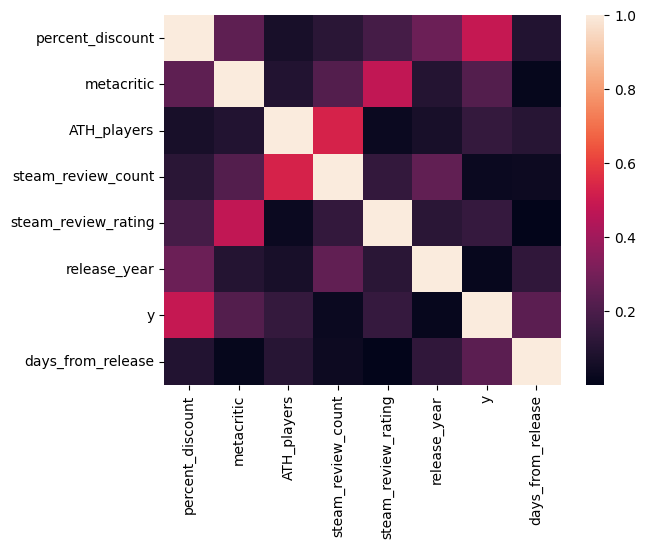

In [27]:
sns.heatmap(df_filter_corr.corr().abs());

In [28]:
problematic_vars = df_filter_corr.loc[:, df_filter_corr.columns!='percent_discount'].corr().abs().unstack().sort_values(ascending=False).loc[lambda x : x >= 0.6][len(df_filter.columns)-3:]
if not len(problematic_vars) == 0:
    print('Correlation Matrix Values Above 0.6')
    print(problematic_vars)

    problematic_vars = problematic_vars.index.to_flat_index().tolist()
    problematic_vars = [item for tup in problematic_vars for item in tup]
    print('\nORDERED BY MULTICOLLINEARITY DANGER')

    for count, elem in sorted(((problematic_vars.count(e), e) for e in set(problematic_vars)), reverse=True):
        print('\'{0}\' - Correlated with {1} other variables.'.format(elem, int(count/2)))
else:
    print('No multicollinarity at a 0.6 level.')

No multicollinarity at a 0.6 level.


In [29]:
cols = [x for x in set(problematic_vars)]
cols.append('percent_discount')
if len(problematic_vars) > 0:
    cols[0], cols[-1] = cols[-1], cols[0]
    chart = df_filter[cols].corr().abs().sort_values('percent_discount', ascending=False)
else: chart = None
chart

In [30]:
df_filter['metacritic'] = df_filter['metacritic'].fillna(df_filter['metacritic'].mean())

In [31]:
try:
    df_filter['publisher'].replace('FromSoftware Inc.', 'FromSoftware, Inc.', inplace = True)
    df_filter['publisher'].replace('FromSoftware, Inc', 'FromSoftware, Inc.', inplace = True)
except: pass

In [32]:
# model = sm.OLS.from_formula("percent_discount ~ days_from_release + publisher + metacritic + ATH_players + steam_review_rating + release_year", data=df_filter)
# result = model.fit()
#result.summary()

In [33]:
df_filter2 = df_filter[['percent_discount', 'days_from_release', 'metacritic', 'ATH_players', 'steam_review_rating', 'release_year']].copy()

In [34]:
#model = sm.OLS.from_formula("percent_discount ~ days_from_release + metacritic + ATH_players + steam_review_rating + release_year", data=df_filter2)
model = sm.OLS.from_formula("percent_discount ~ days_from_release", data=df_filter2)
result = model.fit()

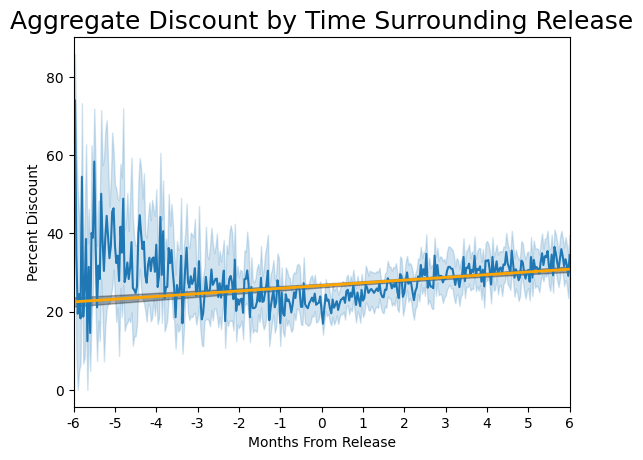

In [35]:
from statsmodels.sandbox.predict_functional import predict_functional

# values = {"metacritic": df_filter2.metacritic.mean(), "ATH_players": df_filter2.ATH_players.mean(),
#           "steam_review_rating": df_filter2.steam_review_rating.mean(), "release_year": df_filter2.release_year.mean()}
values = {"metacritic": '_', "ATH_players": '_', "steam_review_rating": '_', "release_year": '_'}

sns.lineplot(x = df_filter2['days_from_release'], y = df_filter2['percent_discount'])

pr, cb, fv = predict_functional(result, "days_from_release", values=values, ci_method="simultaneous")

ax = sns.lineplot(x = fv, y = pr, lw=2, color = 'orange')
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='black', alpha=0.3)
ax.set_xlabel("Months From Release")
ax.set_ylabel("Percent Discount")

ax.set_xlim(min(xticks), max(xticks))
ax.set(xticks=xticks, xticklabels=xticklabels)

plt.title("Aggregate Discount by Time Surrounding Release", fontsize=18)
plt.show()

In [36]:
length = len(df_filter2.release_year.unique()) // 2
years = sorted(df_filter2.release_year.unique(), reverse=True)[:length*2]

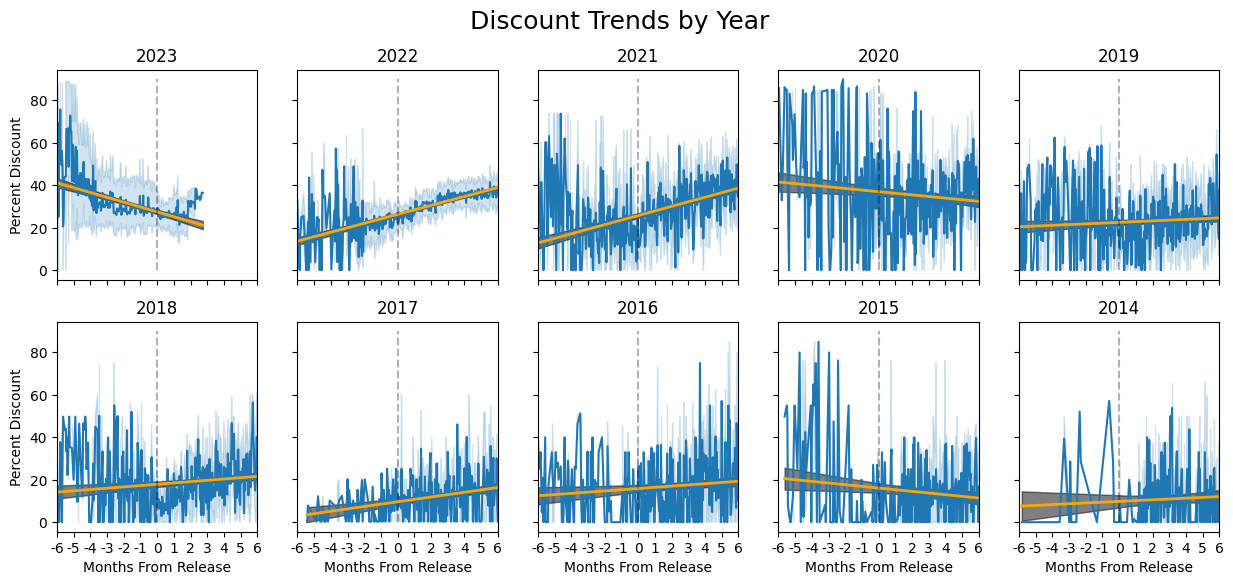

In [37]:
fig, axes = plt.subplots(2, int(len(years)/2), figsize=(15, 6))
plt.subplots_adjust(hspace=0.2, wspace = 0.2)
fig.suptitle("Discount Trends by Year", fontsize=18)

ax0 = 0
ax1 = 0
count = 0

for yr in years:
    sns.lineplot(ax=axes[ax0, ax1], data=df_filter2.loc[df_filter2.release_year == yr], x='days_from_release', y='percent_discount')
    axes[ax0, ax1].set_xlim(min(xticks), max(xticks))
    axes[ax0, ax1].set(xticks=xticks, xticklabels=xticklabels)
    # axes[ax0, ax1].set_xlabel("Months From Release")
    # axes[ax0, ax1].set_ylabel("Percent Discount")
    axes[ax0, ax1].set_title(yr)
    
    model = sm.OLS.from_formula("percent_discount ~ days_from_release", data=df_filter2.loc[df_filter2.release_year == yr])
    result = model.fit()
    pr, cb, fv = predict_functional(result, "days_from_release", values=values)
    sns.lineplot(ax=axes[ax0, ax1], x = fv, y = pr, lw=2, color = 'orange')
    axes[ax0, ax1].fill_between(fv, cb[:, 0], cb[:, 1], color='black', alpha=0.5)
    axes[ax0, ax1].vlines(x = 0, ymin = 0, ymax = 90, linestyles = "dashed", colors = "black", alpha = 0.3)
    
    ax1 += 1
    count += 1
    if count % int(len(years)/2) == 0:
        ax0 += 1
        ax1 = 0

for ax in axes.flat:
    ax.set(xlabel='Months From Release', ylabel='Percent Discount')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

In [38]:
xticks2 = [x - df_filter['days_from_release'].mean() for x in xticks]

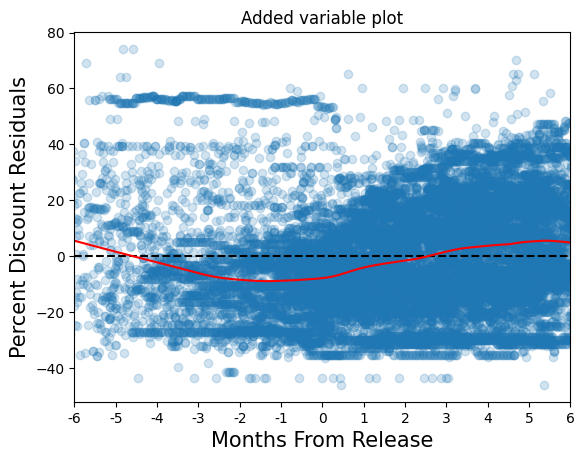

In [39]:
from statsmodels.graphics.regressionplots import add_lowess

# This is an equivalent way to fit a linear regression model, it needs to be
# done this way to be able to make the added variable plot
model = sm.GLM.from_formula("percent_discount ~ days_from_release + metacritic + ATH_players + steam_review_rating + release_year", data=df_filter2)
result3 = model.fit()
result3.summary

fig = result3.plot_added_variable("days_from_release")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)

ax.set_xlim(min(xticks2), max(xticks2))
ax.set(xticks=xticks2, xticklabels=xticklabels)

ax.set_xlabel("Months From Release")
ax.set_ylabel("Percent Discount Residuals")

plt.axhline(y = 0, color = 'black', linestyle = 'dashed')

_ = add_lowess(ax)

In [40]:
import requests

appid = input('Enter Steam appid (Defaults as Manor Lords): ')
if appid == '':
    appid = 1363080
else:
    try:
        appid = int(appid)
    except: 
        print('Please enter valid integer!')

def steam_request(appid):
    url = "http://store.steampowered.com/api/appdetails/"
    parameters = {"appids": appid}    
    try:
        data = requests.get(url, parameters).json()[str(appid)]['data']
        print('Appid Accepted')
        return data
    except:
        return 'Failed. Please check appid.'

steaminfo = steam_request(appid)

Enter Steam appid (Defaults as Manor Lords): 
Appid Accepted


In [41]:
df = df_orig.copy()
release_year = int(re.findall(r'\d\d\d\d', steaminfo['release_date']['date'])[0])
publisher = steaminfo['publishers'][0]
df['release_year'] = df.apply(func, axis=1)

In [42]:
if len(df.loc[(df.publisher == publisher)&(df.release_year == release_year), 'name'].unique()) < 5:
    if len(df.loc[(df.publisher == publisher), 'name'].unique()) < 5:
        raise Exception('Not enough similar items (Publisher).')
    else:
        df_filter3 = df.loc[(df.publisher == publisher)]
else:
    df_filter3 = df.loc[(df.publisher == publisher)&(df.release_year == release_year)]
    if len(df_filter3.name.unique()) < 5:
        raise Exception('Not enough similar items (Publisher).')

In [43]:
for game in df_filter3.name.unique():
        print(game)
        print('    Release Date:', df_filter3.groupby('name')['release_date'].min().loc[[game]][0])

Against the Storm
    Release Date: 2021-10-18
Empires of the Undergrowth
    Release Date: 2017-12-01
Old World
    Release Date: 2020-05-05
Terra Invicta
    Release Date: 2022-09-26
NEBULOUS: Fleet Command
    Release Date: 2022-02-11
Clanfolk
    Release Date: 2022-07-14


In [44]:
max_discount = df_filter3.groupby('name')['percent_discount'].max().round(1)
count = 0
print('No Discount List:')
for game, discount in max_discount.items():
    if discount <= 0:
        count += 1
        print(game)

print('')
print(count, 'of', len(max_discount), 'games did not have a discount in the allotted time frame.')

No Discount List:
Empires of the Undergrowth

1 of 6 games did not have a discount in the allotted time frame.


In [45]:
df_filter4 = df_filter3[['percent_discount', 'days_from_release']].copy()
model = sm.OLS.from_formula("percent_discount ~ days_from_release", data=df_filter4)
result = model.fit()

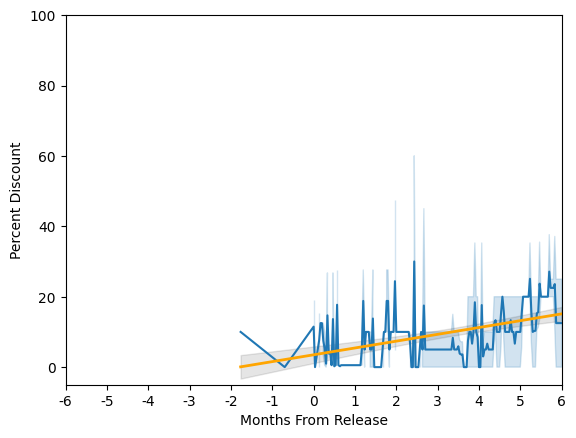

In [46]:
sns.lineplot(x = df_filter3['days_from_release'], y = df_filter3['percent_discount'])

pr, cb, fv = predict_functional(result, "days_from_release", ci_method = 'pointwise')

ax = sns.lineplot(x = fv, y = pr, lw=2, color = 'orange')
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='black', alpha=0.1)
ax.set_xlabel("Months From Release")
ax.set_ylabel("Percent Discount")

ax.set_ylim(-5,100)
ax.set_xlim(min(xticks), max(xticks))
ax.set(xticks=xticks, xticklabels=xticklabels)

plt.show()